In [1]:
import pandas as pd
import numpy as np
import time
import pyodbc
import random
from matplotlib import pyplot
%matplotlib inline

This notebook evaluates different Machine Learning Algorithms used for predicting Customer Response to Direct Mail Campaigns.



In [2]:
def connect(uid = '', pwd = ''):
    server = '' 
    database = 'Data Analytics' 
    uid = uid 
    pwd = pwd 
    conn = pyodbc.connect('Trusted_Connection=yes', 
                           driver='{SQL Server}', 
                           server=server, 
                           database=database, 
                           uid=uid, 
                           pwd=pwd)

    return conn

In [3]:
def getTestData():
    
    conn = connect(uid = '', pwd = '')
    
    query = ("""
                select * from may_dm_model_test
    """)   
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    
    return df

In [11]:
## Get Scored Customers
df_score = pd.read_csv('final_scored_customers.csv')
df_score.customer_id.nunique()

4541547

In [12]:
## Get Actual Response Data
df_test = getTestData()

In [13]:
## Rename customer no to id to have same column name in both data set
df_test = df_test.rename(columns={'customer_no': 'customer_id'})

In [14]:
df_test.head()

,customer_id,response
0,23.0,0
1,65.0,0
2,3866.0,0
3,4328.0,0
4,4709.0,0


In [15]:
df_test.response.value_counts()

0    303680
1     16255
Name: response, dtype: int64

In [16]:
## Merge Response Data and Scored Customer to
new_df = pd.merge(df_score, df_test,  how='inner', on=['customer_id'])
print('new_df :',new_df.shape[0], ' df_score :', df_score.shape[0], ' df_test :', df_test.shape[0]) 

new_df : 319846  df_score : 4541547  df_test : 319935


In [17]:
new_df.head()

,score,customer_id,response
0,0.847425,980072839,0
1,0.814952,9900089390,1
2,0.776584,8109418486,1
3,0.775896,9896725844,1
4,0.775386,9897668676,1


In [18]:
new_df.response.value_counts()

0    303593
1     16253
Name: response, dtype: int64

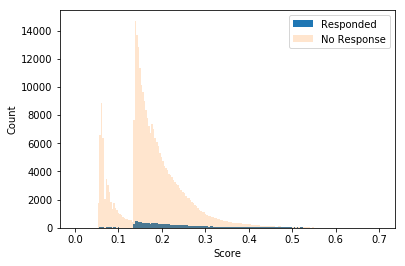

In [19]:
## Score Comparison b/w Responded & No Response dataset

x = new_df.loc[new_df['response'] == 1].score
y = new_df.loc[new_df['response'] == 0].score

bins = np.linspace(0, 0.7, 200)

pyplot.hist(x, bins, alpha=1, label='Responded')
pyplot.hist(y, bins, alpha=0.2, label='No Response')
pyplot.xlabel('Score')
pyplot.ylabel('Count')
pyplot.legend(loc='upper right')
pyplot.show()

The above graph reveals the proportion of Customer Responded to Overall.The Score on X axis is probability of Customer Response i.e. Prediction.


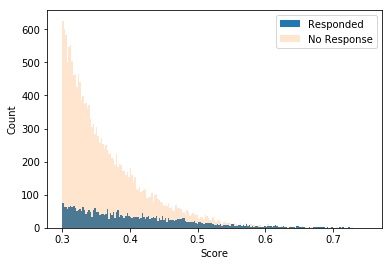

In [20]:
## Score Comparison b/w Responded & No Response dataset with minimum score of .3

x = new_df.loc[(new_df['response'] == 1) & (new_df['score'] > 0.3)].score
y = new_df.loc[(new_df['response'] == 0) & (new_df['score'] > 0.3)].score

bins = np.linspace(0.3, 0.75, 200)

pyplot.hist(x, bins, alpha=1, label='Responded')
pyplot.hist(y, bins, alpha=0.2, label='No Response')
pyplot.xlabel('Score')
pyplot.ylabel('Count')
pyplot.legend(loc='upper right')
pyplot.show()

The tail of the customer responded is promiment than the customer who did not chose to respond which signifies more customer responded with higher score where score is the probability of customer response.

In [21]:
## Get Vital stats
df_compare = pd.DataFrame([])
df_compare[0] = new_df.loc[new_df['response'] == 0].score.describe()
df_compare[1] = new_df.loc[new_df['response'] == 1].score.describe()

In [22]:
## Show vital stats of Responded 1 vs No Response 0
df_compare.head(10)

,0,1
count,303593.000000,16253.000000
mean,0.179072,0.243299
std,0.074628,0.105503
min,0.054103,0.055295
25%,0.141783,0.165698
50%,0.167598,0.212499
75%,0.213669,0.292155
max,0.847425,0.814952


In [23]:
## Get deciles based on Score
new_df['deciles']=  pd.qcut(new_df['score'], 10, labels=False)
new_df.head()

,score,customer_id,response,deciles
0,0.847425,980072839,0,9
1,0.814952,9900089390,1,9
2,0.776584,8109418486,1,9
3,0.775896,9896725844,1,9
4,0.775386,9897668676,1,9


In [24]:
## Get Rounded Score
new_df['roundScore']=  np.round(new_df['score'],2)

In [25]:
## Get Response vs No Response based on Deciles
new_df['response'].groupby(new_df['deciles']).value_counts()

deciles  response
0        0           31788
         1             197
1        0           31202
         1             783
2        0           30974
         1            1010
3        0           30815
         1            1170
4        0           30724
         1            1260
5        0           30533
         1            1452
6        0           30330
         1            1654
7        0           30142
         1            1843
8        0           29759
         1            2225
9        0           27326
         1            4659
Name: response, dtype: int64

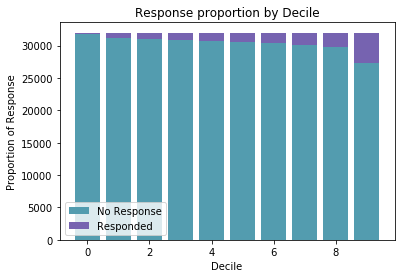

In [26]:
# Get Response by No Response vs Responded
def stackedbarplot(x_data, y_data_list, y_data_names, colors, x_label, y_label, title):
    _, ax = pyplot.subplots()
    # Draw bars, one category at a time
    for i in range(0, len(y_data_list)):
        if i == 0:
            ax.bar(x_data, y_data_list[i], color = colors[i], align = 'center', label = y_data_names[i])
        else:
            ax.bar(x_data, y_data_list[i], color = colors[i], bottom = y_data_list[i - 1], align = 'center', label = y_data_names[i])
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'lower left')

# Call the function to create plot
stackedbarplot(x_data = new_df[['score']].groupby(new_df['deciles']).mean().index.values
               , y_data_list = [new_df.score[new_df['response']==0].groupby(new_df['deciles']).count(), new_df.score[new_df['response']==1].groupby(new_df['deciles']).count()]
               , y_data_names = ['No Response', 'Responded']
               , colors = ['#539caf', '#7663b0']
               , x_label = 'Decile'
               , y_label = 'Proportion of Response'
               , title = 'Response proportion by Decile')

Customers in the topmost decile responded the most as expected.

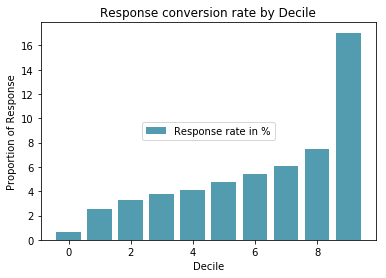

In [27]:
## Response Convertion Rate by Deciles

# Define a function for a stacked bar plot
def stackedbarplot(x_data, y_data_list, y_data_names, colors, x_label, y_label, title):
    _, ax = pyplot.subplots()
    # Draw bars, one category at a time
    for i in range(0, len(y_data_list)):
        if i == 0:
            ax.bar(x_data, y_data_list[i], color = colors[i], align = 'center', label = y_data_names[i])
        else:
            # For each category after the first, the bottom of the
            # bar will be the top of the last category
            ax.bar(x_data, y_data_list[i], color = colors[i], bottom = y_data_list[i - 1], align = 'center', label = y_data_names[i])
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'center')

# Call the function to create plot
stackedbarplot(x_data = new_df[['score']].groupby(new_df['deciles']).mean().index.values
               , y_data_list = [(new_df.score[new_df['response']==1].groupby(new_df['deciles']).count()/new_df.score[new_df['response']==0].groupby(new_df['deciles']).count())*100]
               , y_data_names = ['Response rate in %']
               , colors = ['#539caf']
               , x_label = 'Decile'
               , y_label = 'Proportion of Response'
               , title = 'Response conversion rate by Decile')

The top decile ie 90th decile has the best conversion rate which means the customers who were in the top decile based on predicted score responded the most which signifies the robustness of the Machine Learning Model used.

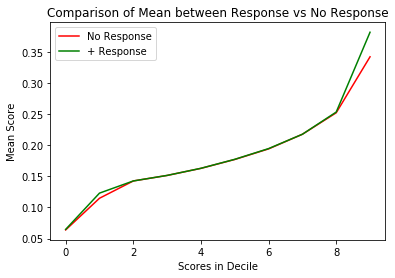

In [28]:
## 'Comparison of Mean between Response vs No Response by Deciles'
pyplot.plot(new_df[['score']].groupby(new_df['deciles']).mean().index.values, new_df.score[new_df['response']==0].groupby(new_df['deciles']).mean(), color='red')
pyplot.plot(new_df[['score']].groupby(new_df['deciles']).mean().index.values, new_df.score[new_df['response']==1].groupby(new_df['deciles']).mean(), color='green')
pyplot.xlabel('Scores in Decile')
pyplot.ylabel('Mean Score')
pyplot.title('Comparison of Mean between Response vs No Response')
pyplot.legend(['No Response', '+ Response'])
pyplot.show()

The mean of the score of customers responded vis a vis customers who did not significantly differ in the top decile.

In [29]:
## Get Scored Customers with all the Algo. scores
df_score2 = pd.read_csv('scored_customers_March.csv')
## Merge 
new_df2 = pd.merge(df_score2, df_score,  how='inner', on=['customer_id'])

In [30]:
## Sanity check - Count Should be same
print(df_score.shape[0], df_score2.shape[0], new_df2.shape[0])

4541547 4541547 4541547


In [33]:
## Get Rounded Score
new_df2['roundScore']=  np.round(new_df2['score_x'],2)
new_df2.head()

,extra_trees1_score,extra_trees1_score_class,neural_net1_score,neural_net1_score_class,logistic_regression1_score,logistic_regression1_score_class,nearest_neighbor1_score,nearest_neighbor1_score_class,random_forest1_score,random_forest1_score_class,score_x,score_class,customer_id,score_y,roundScore
0,0.105602,0,0.008603,0,0.233868,0,0.0,0,0.085728,0,0.086760,0,8889073736,0.086760,0.09
1,0.049761,0,0.010383,0,0.255827,0,0.0,0,0.050027,0,0.073200,0,9900557688,0.073200,0.07
2,0.049761,0,0.009127,0,0.234252,0,0.0,0,0.066691,0,0.071966,0,9900663765,0.071966,0.07
3,0.049761,0,0.004313,0,0.229075,0,0.0,0,0.070969,0,0.070824,0,9903635032,0.070824,0.07
4,0.049761,0,0.019585,0,0.215065,0,0.0,0,0.000000,0,0.056882,0,9904507435,0.056882,0.06


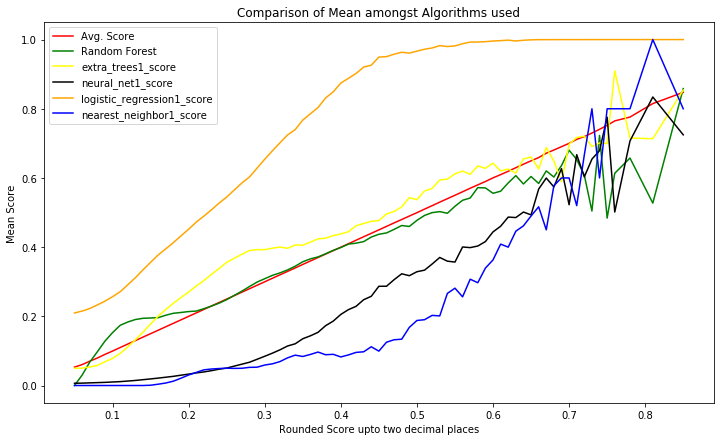

In [34]:
## 'Comparison of Mean between Response vs No Response'
pyplot.rcParams['figure.figsize'] = (12, 7)
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.score_x.groupby(new_df2['roundScore']).mean(), color='red')
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.random_forest1_score.groupby(new_df2['roundScore']).mean(), color='green')
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.extra_trees1_score.groupby(new_df2['roundScore']).mean(), color='yellow')
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.neural_net1_score.groupby(new_df2['roundScore']).mean(), color='black')
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.logistic_regression1_score.groupby(new_df2['roundScore']).mean(), color='orange')
pyplot.plot(new_df2[['score_x']].groupby(new_df2['roundScore']).mean().index.values, new_df2.nearest_neighbor1_score.groupby(new_df2['roundScore']).mean(), color='blue')
pyplot.xlabel('Rounded Score upto two decimal places')
pyplot.ylabel('Mean Score')
pyplot.title('Comparison of Mean amongst Algorithms used')
pyplot.legend(['Avg. Score', 'Random Forest', 'extra_trees1_score', 'neural_net1_score', 'logistic_regression1_score', 'nearest_neighbor1_score' ])
#pyplot.figure(figsize=(5,5))
pyplot.show()

Logistic Regression has signifincantly larger mean than the rest of the Algorithms used.

In [35]:
## Add Response to all Algorithm dataset
## Merge Response Data and Scored Customers
new_df3 = pd.merge(new_df2, df_test,  how='inner', on=['customer_id'])

In [36]:
## Get deciles based on Score
new_df3['deciles']=  pd.qcut(new_df3['score_x'], 10, labels=False)

In [39]:
mlDF33 = pd.DataFrame([])
mlDF33['customer_id'] = new_df3['customer_id']
mlDF33['extraTree'] = new_df3['extra_trees1_score']
mlDF33['neuralNet'] = new_df3['neural_net1_score']
mlDF33['logisticRegression'] = new_df3['logistic_regression1_score']
mlDF33['nearestNeighbor'] = new_df3['nearest_neighbor1_score']
mlDF33['randomForest'] = new_df3['random_forest1_score']
mlDF33['randomForest'] = new_df3['random_forest1_score']
mlDF33['Average'] = new_df3['score_x']
mlDF33['roundScore'] = new_df3['roundScore']
mlDF33['deciles'] = new_df3['deciles']
mlDF33['response'] = new_df3['response']
mlDF33.to_csv(('ResponseData.csv'), index = False)
mlDF33.shape[0]

319846

In [38]:
new_df3.response.head()

0    0
1    0
2    0
3    0
4    1
Name: response, dtype: int64

In [114]:
## Mean Score based on Rounded Score for Positive Response
df_resp = pd.DataFrame([])
df_resp['No_resp'] = new_df3.score_x[new_df3['response']==0].groupby(new_df3['roundScore']).mean()
df_resp['respbyAvg'] = new_df3.score_x[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp['respbyExtra'] = new_df3.extra_trees1_score[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp['respbyNeural'] = new_df3.neural_net1_score[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp['respbyLogistic'] = new_df3.logistic_regression1_score[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp['respbyNN'] = new_df3.nearest_neighbor1_score[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp['respbyRM'] = new_df3.random_forest1_score[new_df3['response']==1].groupby(new_df3['roundScore']).mean()
df_resp = df_resp.reset_index()
df_resp.fillna(value=0, inplace=True)

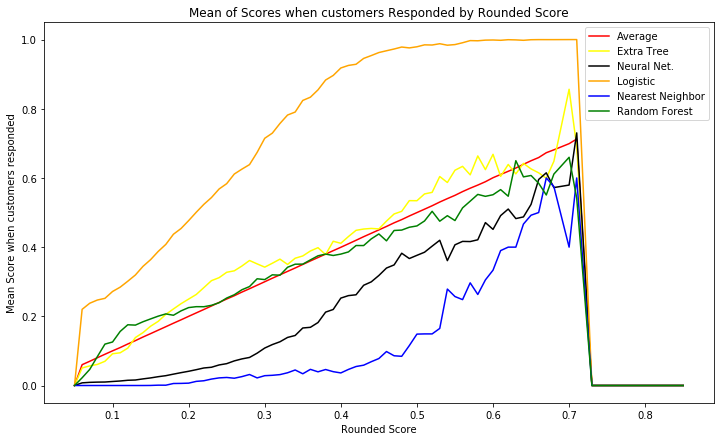

In [125]:
## 'Comparison of Mean between Response vs No Response'
pyplot.rcParams['figure.figsize'] = (12, 7)
pyplot.plot(df_resp['roundScore'], df_resp['respbyAvg'], color='red')
pyplot.plot(df_resp['roundScore'], df_resp['respbyExtra'], color='yellow')
pyplot.plot(df_resp['roundScore'], df_resp['respbyNeural'], color='black')
pyplot.plot(df_resp['roundScore'], df_resp['respbyLogistic'], color='orange')
pyplot.plot(df_resp['roundScore'], df_resp['respbyNN'], color='blue')
pyplot.plot(df_resp['roundScore'], df_resp['respbyRM'], color='green')
pyplot.ylabel('Mean Score when customers responded')
pyplot.xlabel('Rounded Score')
pyplot.title('Mean of Scores when customers Responded by Rounded Score')
pyplot.legend(['Average', 'Extra Tree', 'Neural Net.', 'Logistic', 'Nearest Neighbor', 'Random Forest'])
#pyplot.figure(figsize=(5,5))
pyplot.show()

In [122]:
df_resp2 = pd.DataFrame([])
df_resp2 = new_df3[new_df3['response']==1]

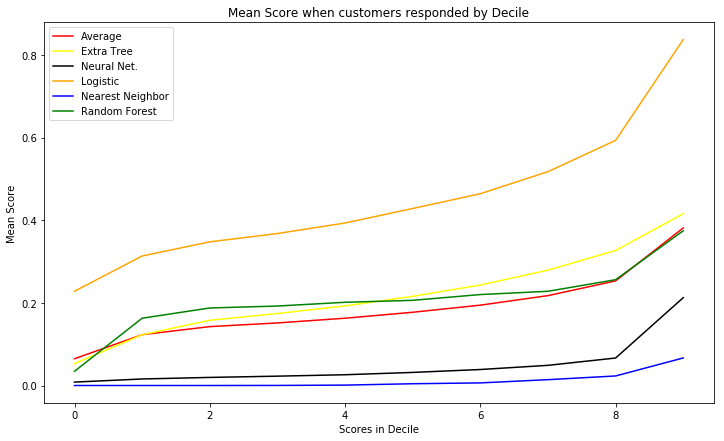

In [126]:
## 'Comparison of Mean between Response vs No Response by Deciles'
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.score_x.groupby(df_resp2['deciles']).mean(), color='red')
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.extra_trees1_score.groupby(df_resp2['deciles']).mean(), color='yellow')
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.neural_net1_score.groupby(df_resp2['deciles']).mean(), color='black')
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.logistic_regression1_score.groupby(df_resp2['deciles']).mean(), color='orange')
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.nearest_neighbor1_score.groupby(df_resp2['deciles']).mean(), color='blue')
pyplot.plot(df_resp2[['score_x']].groupby(df_resp2['deciles']).mean().index.values, df_resp2.random_forest1_score.groupby(df_resp2['deciles']).mean(), color='green')
pyplot.xlabel('Scores in Decile')
pyplot.ylabel('Mean Score')
pyplot.title('Mean Score when customers responded by Decile')
pyplot.legend(['Average', 'Extra Tree', 'Neural Net.', 'Logistic', 'Nearest Neighbor', 'Random Forest'])
pyplot.show()

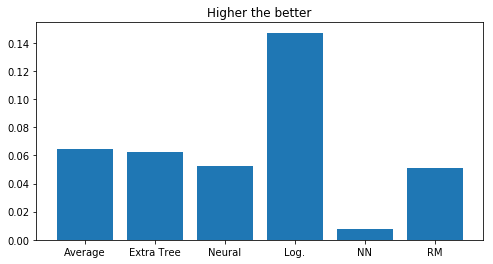

In [142]:
## Diff. b/w Mean Score of customers who responded - Mean of customer who did not

pyplot.rcParams['figure.figsize'] = (8, 4)
x = np.arange(6)
pyplot.bar(x, height = [
    (new_df3.score_x[new_df3['response']==1].mean() - new_df3.score_x[new_df3['response']==0].mean()),
    (new_df3.extra_trees1_score[new_df3['response']==1].mean() - new_df3.extra_trees1_score[new_df3['response']==0].mean()),
    (new_df3.neural_net1_score[new_df3['response']==1].mean() - new_df3.neural_net1_score[new_df3['response']==0].mean()),
    (new_df3.logistic_regression1_score[new_df3['response']==1].mean() - new_df3.logistic_regression1_score[new_df3['response']==0].mean()),
    (new_df3.nearest_neighbor1_score[new_df3['response']==1].mean() - new_df3.nearest_neighbor1_score[new_df3['response']==0].mean()),
    (new_df3.random_forest1_score[new_df3['response']==1].mean() - new_df3.random_forest1_score[new_df3['response']==0].mean())
     ])
pyplot.xticks(x, ['Average', 'Extra Tree','Neural','Log.', 'NN', 'RM'])
pyplot.title('Higher, the better');

As seen in the above graph, Logistic Regression on an average assigned significanly larger score to the customers than the rest of the ML Algorithms.

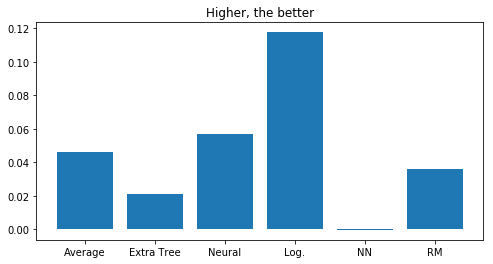

In [173]:
## 90% Positive Ouptput remains in the top 5 deciles, hence consider deciles > 4

pyplot.rcParams['figure.figsize'] = (8, 4)
x = np.arange(6)
n = 4  
pyplot.bar(x, height = [
    (new_df3.score_x[(new_df3['response']==1) & (new_df3['deciles']>n)].mean() - new_df3.score_x[(new_df3['response']==0) & (new_df3['deciles']>n)].mean()),
    (new_df3.extra_trees1_score[(new_df3['response']==1) & (new_df3['deciles']>n)].mean() - new_df3.extra_trees1_score[(new_df3['response']==0)  & (new_df3['deciles']>n)].mean()),
    (new_df3.neural_net1_score[(new_df3['response']==1)  & (new_df3['deciles']>n)].mean() - new_df3.neural_net1_score[(new_df3['response']==0) & (new_df3['deciles']>n)].mean()),
    (new_df3.logistic_regression1_score[(new_df3['response']==1) & (new_df3['deciles']>n)].mean() - new_df3.logistic_regression1_score[(new_df3['response']==0) & (new_df3['deciles']>n)].mean()),
    (new_df3.nearest_neighbor1_score[(new_df3['response']==1) & (new_df3['deciles']>n)].mean() - new_df3.nearest_neighbor1_score[(new_df3['response']==0) & (new_df3['deciles']>n)].mean()),
    (new_df3.random_forest1_score[(new_df3['response']==1) & (new_df3['deciles']>n)].mean() - new_df3.random_forest1_score[(new_df3['response']==0) & (new_df3['deciles']>n)].mean())
     ])
pyplot.xticks(x, ['Average', 'Extra Tree','Neural','Log.', 'NN', 'RM'])
pyplot.title('Higher, the better');

When considering the top 50 % of the customers based on Score, the Nearest Neigbour Algorithms has virtually no difference between the scores of the customer who responded viz a viz who did not. Surprisingly the Extra Tree Algo. also did performed that well for the top 50%.

In [165]:
new_df3.response[new_df3['deciles']>4].value_counts()

0    148090
1     11833
Name: response, dtype: int64

In [286]:
## !!!! --- II Part  --- !!!! 

In [287]:
new_df3.head()

,extra_trees1_score,extra_trees1_score_class,neural_net1_score,neural_net1_score_class,logistic_regression1_score,logistic_regression1_score_class,nearest_neighbor1_score,nearest_neighbor1_score_class,random_forest1_score,random_forest1_score_class,score_x,score_class,customer_id,score_y,roundScore,response,deciles
0,0.284693,0,0.012015,0,0.277753,0,0.0,0,0.168533,0,0.148599,0,9905077727,0.148599,0.15,0,3
1,0.306429,0,0.015777,0,0.368497,0,0.0,0,0.232450,0,0.184631,0,9908618186,0.184631,0.18,0,5
2,0.132535,0,0.033061,0,0.479017,1,0.0,0,0.241758,0,0.177274,0,980103911,0.177274,0.18,0,5
3,0.138661,0,0.019143,0,0.303654,0,0.0,0,0.353851,0,0.163062,0,8890344209,0.163062,0.16,0,4
4,0.344784,0,0.026560,0,0.458138,1,0.0,0,0.192233,0,0.204343,0,9896568342,0.204343,0.20,1,6


In [288]:
mlDF = pd.DataFrame([])
mlDF['extraTree'] = new_df3['extra_trees1_score']
mlDF['neuralNet'] = new_df3['neural_net1_score']
mlDF['logisticRegression'] = new_df3['logistic_regression1_score']
mlDF['nearestNeighbor'] = new_df3['nearest_neighbor1_score']
mlDF['randomForest'] = new_df3['random_forest1_score']
mlDF['response'] = new_df3['response']
#mlDF.to_csv(('mlDF.csv'), index = False)
mlDF.shape[0]

319846

In [289]:

mlDF2 = pd.DataFrame([])
mlDF2['extraTree'] = new_df3.extra_trees1_score[(new_df3['response']==1)]
mlDF2['neuralNet'] = new_df3.neural_net1_score[(new_df3['response']==1)]
mlDF2['logisticRegression'] = new_df3.logistic_regression1_score[(new_df3['response']==1)]
mlDF2['nearestNeighbor'] = new_df3.nearest_neighbor1_score[(new_df3['response']==1)]
mlDF2['randomForest'] = new_df3.random_forest1_score[(new_df3['response']==1)]
mlDF2['response'] = new_df3.response[(new_df3['response']==1)]
#mlDF2.to_csv(('mlDF2.csv'), index = False)
mlDF2.shape[0]

16253

In [290]:
mlDF2.head()

,extraTree,neuralNet,logisticRegression,nearestNeighbor,randomForest,response
4,0.344784,0.026560,0.458138,0.0,0.192233,1
31,0.211977,0.234322,0.638249,0.0,0.429716,1
105,0.221896,0.023902,0.427112,0.0,0.087816,1
126,0.518036,0.109079,0.776857,0.0,0.213442,1
129,0.355396,0.100663,0.738618,0.0,0.182827,1


In [291]:
# DO NOT USE

a = np.array(mlDF[['extraTree', 'neuralNet','logisticRegression','nearestNeighbor','randomForest']].values.tolist())
b = np.array(mlDF.response.values.tolist())
#x = np.linalg.solve(a, b)
x = np.linalg.lstsq(a, b)
x


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


(array([-0.02833912,  0.74902302,  0.06479118, -0.02846758,  0.01302174]),
 array([14677.0109443]),
 5,
 array([316.9822807 ,  67.42859465,  46.95429872,  34.66157905,
         21.84283858]))

In [292]:
mlDF3 = mlDF.sample(25000)
mlDF2 = mlDF3.append(mlDF2)
mlDF2.response.value_counts()

0    23685
1    17568
Name: response, dtype: int64

In [293]:
a = np.array(mlDF2[['extraTree', 'neuralNet','logisticRegression','nearestNeighbor','randomForest']].values.tolist())
b = np.array(mlDF2.response.values.tolist())
#x = np.linalg.solve(a, b)
x = np.linalg.lstsq(a, b)
x

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


(array([-0.10793315,  0.07550423,  0.8912468 , -0.18989029,  0.12982842]),
 array([8678.30744403]),
 5,
 array([128.79462408,  24.34678829,  18.73405898,  14.52050321,
         11.50756917]))

In [294]:
mlDF.head()

,extraTree,neuralNet,logisticRegression,nearestNeighbor,randomForest,response
0,0.284693,0.012015,0.277753,0.0,0.168533,0
1,0.306429,0.015777,0.368497,0.0,0.232450,0
2,0.132535,0.033061,0.479017,0.0,0.241758,0
3,0.138661,0.019143,0.303654,0.0,0.353851,0
4,0.344784,0.026560,0.458138,0.0,0.192233,1


In [260]:
algoDF = pd.DataFrame([])
algoDF['extraTree'] = mlDF.extraTree.describe()
algoDF['neuralNet'] = mlDF.neuralNet.describe()
algoDF['logisticRegression'] = mlDF.logisticRegression.describe()
algoDF['nearestNeighbor'] = mlDF.nearestNeighbor.describe()
algoDF['randomForest'] = mlDF.randomForest.describe()

In [295]:
algoDF.head(10)

,extraTree,neuralNet,logisticRegression,nearestNeighbor,randomForest
count,319846.000000,319846.000000,319846.000000,319846.000000,319846.000000
mean,0.223826,0.038283,0.422066,0.017548,0.209955
std,0.131628,0.053007,0.163339,0.064883,0.124030
min,0.000000,0.000310,0.200918,0.000000,0.000000
25%,0.121425,0.012868,0.306455,0.000000,0.118028
50%,0.211195,0.022694,0.398086,0.000000,0.202674
75%,0.301121,0.040495,0.493925,0.000000,0.292964
max,0.909721,0.868075,1.000000,1.000000,0.882420


In [296]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=pyplot.cm.inferno_r):
    pyplot.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    pyplot.xticks(tick_marks, df_confusion.columns, rotation=45)
    pyplot.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    pyplot.ylabel(df_confusion.index.name)
    pyplot.xlabel(df_confusion.columns.name)


In [298]:
## extraTree
y_actu = pd.Series(mlDF.extraTree, name='Actual')
y_pred = pd.Series(mlDF.response, name='Predicted')
#df_confusion = pd.crosstab(y_actu, y_pred)

In [299]:
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0

In [300]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [301]:
df_confusion

Predicted,0,1,All
Actual,,,
0.0,273830,13061,286891
1.0,29763,3192,32955
All,303593,16253,319846


In [302]:
## Extra Tree F1
print(f1_score(y_actu, y_pred, average="macro"))

0.5286057227460614


In [303]:
## neuralNet
y_actu = pd.Series(mlDF.neuralNet, name='Actual')
y_pred = pd.Series(mlDF.response, name='Predicted')
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0
df_confusion_net = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion_net

Predicted,0,1,All
Actual,,,
0.0,302897,15667,318564
1.0,696,586,1282
All,303593,16253,319846


In [304]:
## NeuralNet F1
print(f1_score(y_actu, y_pred, average="macro"))

0.5202686588223283


In [305]:
## logisticRegression
y_actu = pd.Series(mlDF.logisticRegression, name='Actual')
y_pred = pd.Series(mlDF.response, name='Predicted')
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0
df_confusion_log = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion_log

Predicted,0,1,All
Actual,,,
0.0,157824,4199,162023
1.0,145769,12054,157823
All,303593,16253,319846


In [306]:
## Logistic F1
print(f1_score(y_actu, y_pred, average="macro"))

0.4082030410005052


In [307]:
## nearestNeighbor
y_actu = pd.Series(mlDF.nearestNeighbor, name='Actual')
y_pred = pd.Series(mlDF.response, name='Predicted')
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0
df_confusion_NN = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion_NN

Predicted,0,1,All
Actual,,,
0.0,303164,16178,319342
1.0,429,75,504
All,303593,16253,319846


In [308]:
## nearestNeighbor F1
print(f1_score(y_actu, y_pred, average="macro"))

0.4911461003468643


In [309]:
## randomForest
y_actu = pd.Series(mlDF.randomForest, name='Actual')
y_pred = pd.Series(mlDF.response, name='Predicted')
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0
df_confusion_RM = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion_RM

Predicted,0,1,All
Actual,,,
0.0,283000,13769,296769
1.0,20593,2484,23077
All,303593,16253,319846


In [310]:
## randomForest F1
print(f1_score(y_actu, y_pred, average="macro"))

0.5345401607696689


In [311]:
## Average
y_actu = pd.Series(new_df3.score_y, name='Actual')
y_pred = pd.Series(new_df3.response, name='Predicted')
## Threshold =  .4
y_actu[y_actu > 0.4] = 1
y_actu[y_actu <= 0.4] = 0
df_confusion_avg = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion_avg


Predicted,0,1,All
Actual,,,
0.0,299218,14601,313819
1.0,4375,1652,6027
All,303593,16253,319846


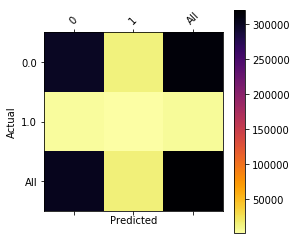

In [282]:
plot_confusion_matrix(df_confusion_avg)

Key Findings:
    
    1. k-NN algorithm negatively impacts the prediction in the top 30 decile
    2. Logistic Regression has high recall and low precision
    3. Stacking of ML algorithm, still the best overall option as it has the best F1 score
    4. Removing k-NN from the ML stack might help in optimizing the overall predictions.